## Importing necessary packages

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

## Reading and cleaning the data

In [4]:
# Reading the data in a dataframe
df_all = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')

In [5]:
df_all

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


#### As you can see we have so many information about the individuals. We will clean the dataframe and only keep those useful for us in the calculation.  

In [6]:
# Creating a new dataframe with selected column
df = df_all[['id','sex','race','age_cat','decile_score','score_text','two_year_recid']]

In [7]:
df

,id,sex,race,age_cat,decile_score,score_text,two_year_recid
0,1,Male,Other,Greater than 45,1,Low,0
1,3,Male,African-American,25 - 45,3,Low,1
2,4,Male,African-American,Less than 25,4,Low,1
3,5,Male,African-American,Less than 25,8,High,0
4,6,Male,Other,25 - 45,1,Low,0
...,...,...,...,...,...,...,...
7209,10996,Male,African-American,Less than 25,7,Medium,0
7210,10997,Male,African-American,Less than 25,3,Low,0
7211,10999,Male,Other,Greater than 45,1,Low,0
7212,11000,Female,African-American,25 - 45,2,Low,0


In [8]:
print(df['decile_score'].max()) # Maximum value of score

10


In [9]:
print(df['decile_score'].min()) # Minimum value of score

1


#### As defined by Propublica, the score from the COMPAS algorithm ranges from 1 to 10 with 1 being lowest risk and 10 being the highest. 

#### For the simplicity in Aequitas, we convert this to binary classification. The 'Low' score is assigned value of 0 while the 'Medium' and 'High' are assigned value of 1. 

#### We also change the names of the columns and delete one more column. 

In [10]:
df.rename(columns = {'score_text' : 'Score', 'two_year_recid' : 'Labels'}, inplace = True)
df.drop (columns = {'decile_score'}, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
df

,id,sex,race,age_cat,Score,Labels
0,1,Male,Other,Greater than 45,Low,0
1,3,Male,African-American,25 - 45,Low,1
2,4,Male,African-American,Less than 25,Low,1
3,5,Male,African-American,Less than 25,High,0
4,6,Male,Other,25 - 45,Low,0
...,...,...,...,...,...,...
7209,10996,Male,African-American,Less than 25,Medium,0
7210,10997,Male,African-American,Less than 25,Low,0
7211,10999,Male,Other,Greater than 45,Low,0
7212,11000,Female,African-American,25 - 45,Low,0


In [12]:
df['Score'].replace(({'Low':'0','Medium':'1','High':'1'}), inplace = True)
df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,id,sex,race,age_cat,Score,Labels
0,1,Male,Other,Greater than 45,0,0
1,3,Male,African-American,25 - 45,0,1
2,4,Male,African-American,Less than 25,0,1
3,5,Male,African-American,Less than 25,1,0
4,6,Male,Other,25 - 45,0,0
...,...,...,...,...,...,...
7209,10996,Male,African-American,Less than 25,1,0
7210,10997,Male,African-American,Less than 25,0,0
7211,10999,Male,Other,Greater than 45,0,0
7212,11000,Female,African-American,25 - 45,0,0


## Understanding the distribution of data

Here, we see how the data is distributed in terms of sex, age groups and race. 

In [13]:
df.head() # First 5 records

,id,sex,race,age_cat,Score,Labels
0,1,Male,Other,Greater than 45,0,0
1,3,Male,African-American,25 - 45,0,1
2,4,Male,African-American,Less than 25,0,1
3,5,Male,African-American,Less than 25,1,0
4,6,Male,Other,25 - 45,0,0


In [14]:
df.shape # Number of rows and columns

(7214, 6)

Text(0.5, 0, 'Sex')

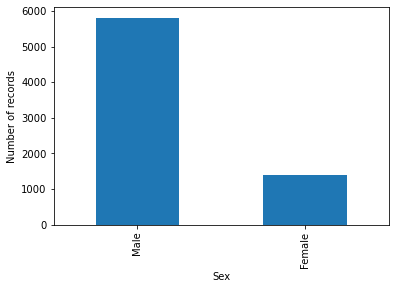

In [15]:
# Sex data

ax=(df['sex'].value_counts()).plot.bar()
ax.set_ylabel("Number of records")
ax.set_xlabel("Sex")

In [16]:
#Race data

df['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

Text(0.5, 0, 'Race')

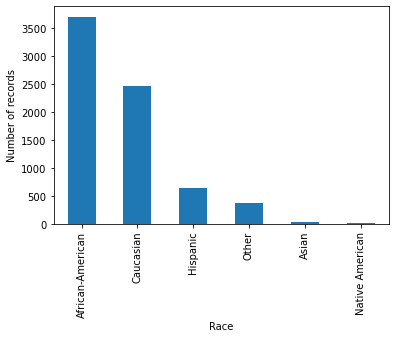

In [17]:
ax=(df['race'].value_counts()).plot.bar()
ax.set_ylabel("Number of records")
ax.set_xlabel("Race")

Text(0.5, 0, 'Age category')

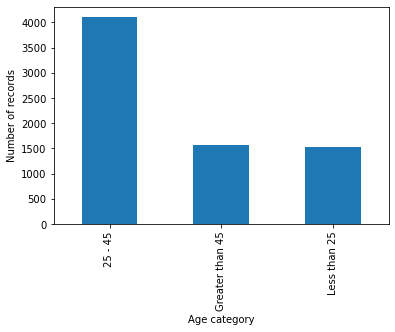

In [18]:
# Age category data

ax=(df['age_cat'].value_counts()).plot.bar()
ax.set_ylabel("Number of records")
ax.set_xlabel("Age category")

#### This table below gives us short summary of all our records based on sex, race, age category and their corresponding count in the records

In [19]:
# df.groupby(['sex','age_cat','race'])[['id']].count()

## Algorithm score against specific groups

We look at how the algorithm has made the prediction for re-committing the crimes for specific groups of people.

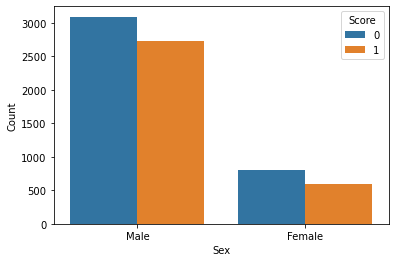

In [20]:
# Score vs Sex

ax = sns.countplot(x="sex", hue="Score", data=df)
ax.set(xlabel='Sex', ylabel='Count')
fig = ax.get_figure()
fig.savefig("score_vs_sex.png", dpi= 200)

In [21]:
df.groupby(['sex','Score'])[['id']].count() # id column gives the frequency

id
sex    Score      
Female 0       804
       1       591
Male   0      3093
       1      2726

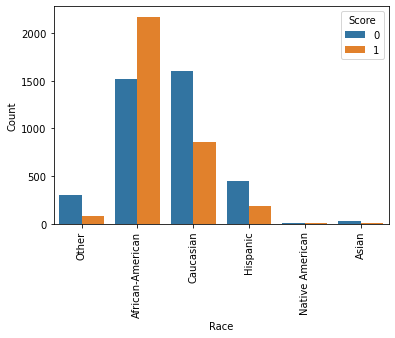

In [22]:
# Score vs Race

ax = sns.countplot(x="race", hue="Score", data=df)
ax.set(xlabel='Race', ylabel='Count')
plt.xticks(rotation=90)
fig = ax.get_figure()
fig.savefig("score_vs_race.png", dpi= 200, bbox_inches = 'tight')

In [23]:
df.groupby(['race','Score'])[['id']].count() # id column gives the frequency

id
race             Score      
African-American 0      1522
                 1      2174
Asian            0        24
                 1         8
Caucasian        0      1600
                 1       854
Hispanic         0       447
                 1       190
Native American  0         6
                 1        12
Other            0       298
                 1        79

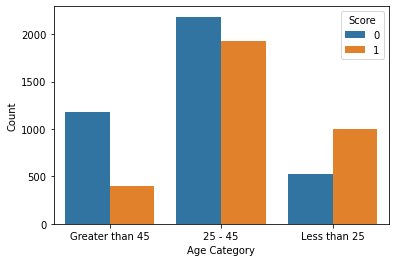

In [24]:
# Score vs Age category

ax = sns.countplot(x="age_cat", hue="Score", data=df)
ax.set(xlabel='Age Category', ylabel='Count')
fig = ax.get_figure()
fig.savefig("score_vs_age.png", dpi= 200)
# plt.xticks(rotation=90)

In [25]:
df.groupby(['age_cat','Score'])[['id']].count() # id column gives the frequency

id
age_cat         Score      
25 - 45         0      2185
                1      1924
Greater than 45 0      1182
                1       394
Less than 25    0       530
                1       999

## Label value against specific groups

We now see how the individuals have performed in real life and compare it with the output from model. 

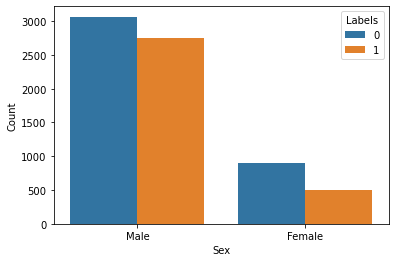

In [26]:
# Label value vs Sex

ax = sns.countplot(x="sex", hue='Labels', data=df)
ax.set(xlabel='Sex', ylabel='Count')
fig = ax.get_figure()
fig.savefig("label_vs_sex.png", dpi= 200)

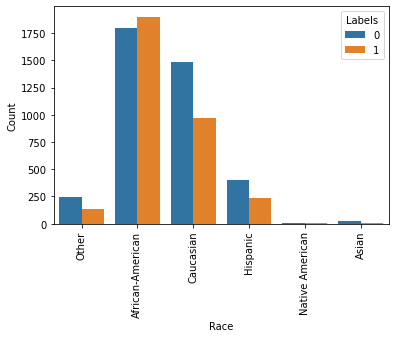

In [27]:
# Label vs Race

ax = sns.countplot(x="race", hue="Labels", data=df)
ax.set(xlabel='Race', ylabel='Count')
plt.xticks(rotation=90)
fig = ax.get_figure()
fig.savefig("label_vs_race.png", dpi= 200, bbox_inches = 'tight')

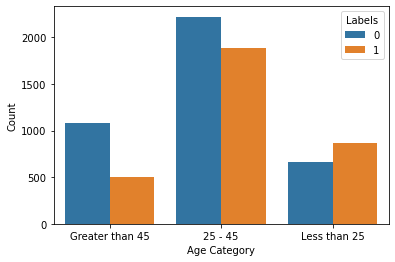

In [28]:
# Label vs Age category

ax = sns.countplot(x="age_cat", hue="Labels", data=df)
ax.set(xlabel='Age Category', ylabel='Count')
fig = ax.get_figure()
fig.savefig("label_vs_age.png", dpi= 200)

## Confusion table and fairness audit

In [29]:
df

,id,sex,race,age_cat,Score,Labels
0,1,Male,Other,Greater than 45,0,0
1,3,Male,African-American,25 - 45,0,1
2,4,Male,African-American,Less than 25,0,1
3,5,Male,African-American,Less than 25,1,0
4,6,Male,Other,25 - 45,0,0
...,...,...,...,...,...,...
7209,10996,Male,African-American,Less than 25,1,0
7210,10997,Male,African-American,Less than 25,0,0
7211,10999,Male,Other,Greater than 45,0,0
7212,11000,Female,African-American,25 - 45,0,0


In [30]:
# As Aequitas takes specific column name for score and label, creating a new Aequitas friendly dataframe. 

df2 = df.copy()

In [31]:
df2.rename(columns = {'Score' : 'score', 'Labels' : 'label_value'}, inplace = True)
df2

,id,sex,race,age_cat,score,label_value
0,1,Male,Other,Greater than 45,0,0
1,3,Male,African-American,25 - 45,0,1
2,4,Male,African-American,Less than 25,0,1
3,5,Male,African-American,Less than 25,1,0
4,6,Male,Other,25 - 45,0,0
...,...,...,...,...,...,...
7209,10996,Male,African-American,Less than 25,1,0
7210,10997,Male,African-American,Less than 25,0,0
7211,10999,Male,Other,Greater than 45,0,0
7212,11000,Female,African-American,25 - 45,0,0


#### Since fairness metrics are based on the confusion matrix, we look at the components of confusion matrix, True Positives, True Negatives, False Positives and False Negatives. 

#####  If labels = 1 and Score = 1, it is TP. This is correct classification. 
##### If labels = 0 and Score = 1, it is FP. This is incorrect classification.
##### If labels = 0 and Score = 0, it is TN. This is correct classification.
##### If labels = 1 and Score = 0, it is FN. This is incorrect classification.

In [32]:
# We will use Native American race as our reference group to compare other races in the data. 

reference = {'race':'Native American'}
race = list(reference.keys())

In [33]:
# Aequitas Group Class
g = Group()

# Creates a dataframe with many metrics of confusion matrix for 'race' sub group
xtab, _ = g.get_crosstabs(df2, attr_cols = race) 
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,3317,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,...,0.588203,805,532,990,1369,1901,1795,3696,7214,0.514340
1,0,binary 0/1,3317,race,Asian,0.666667,0.913043,0.125000,0.250000,0.086957,...,0.250000,2,3,21,6,9,23,32,7214,0.281250
2,0,binary 0/1,3317,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,...,0.348003,349,461,1139,505,966,1488,2454,7214,0.393643
3,0,binary 0/1,3317,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,...,0.298273,87,129,318,103,232,405,637,7214,0.364207
4,0,binary 0/1,3317,race,Native American,0.900000,0.625000,0.166667,0.250000,0.375000,...,0.666667,3,1,5,9,10,8,18,7214,0.555556
5,0,binary 0/1,3317,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,...,0.209549,36,90,208,43,133,244,377,7214,0.352785


##### False discovery rate (FDR) in this case is the number of people who have been identified as the potential for recomitting the crime by the model but they don't do it in real. 

##### Equal to False Positive (FP) divided by the sum of FP and True Positive (TP) . 

##### It's the score prediction of 1 by the model when it should have been 0. 

##### So, we want to be fair towards racial group (for those whose prediction was wrong), so we choose FDR Parity as our metric. We want to see how the model behaves towards other races compared to native Americans. 

In [34]:
metrics = ['fdr']

In [35]:
# Disparity tolerance can be set as an arbitrary value. 
# It's an indication on how far the degree of disparity between different groups can be tolerated.

disparity_tolerance = 1.1

In [36]:
# The get_disparity_predefined_groups() function of Bias class calculates reference group based on the data we provided earlier.

b = Bias()

bdf = b.get_disparity_predefined_groups(xtab, original_df=df2, ref_groups_dict=reference)
bdf

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,3317,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,...,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American
1,0,binary 0/1,3317,race,Asian,0.666667,0.913043,0.125000,0.250000,0.086957,...,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American
2,0,binary 0/1,3317,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,...,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American
3,0,binary 0/1,3317,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,...,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American
4,0,binary 0/1,3317,race,Native American,0.900000,0.625000,0.166667,0.250000,0.375000,...,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American
5,0,binary 0/1,3317,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,...,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American,Native American


In [37]:
# Checking the disparity in 'Race' group

ap.disparity(bdf, metrics, 'race', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

#### Since the proportion of people wrongly predicted by model for recidivism is slightly higher for Hispanic, Others, Caucasian and African American race compared to Native American and Asian, we can say that the system is biased towards some race. 